## Load packages

In [1]:
# Import required packages
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import time
import sys
import json
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score
from PIL import Image

In [2]:
# Use the following command to install additional packages
# !{sys.executable} -m pip install PACKAGENAME

In [3]:
# Load additionaly installed packages
# import PACKAGENAME
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Load data

In [4]:
# Create file path to the data
val_dir = './data/ValidationData'

# Create lists containing all image paths
val_normal = [os.path.join(val_dir, 'good/{}').format(i) for i in os.listdir(os.path.join(val_dir, 'good'))]
val_fluten = [os.path.join(val_dir, 'bad/{}').format(i) for i in os.listdir(os.path.join(val_dir, 'bad'))]
val_images = val_normal + val_fluten
np.random.shuffle(val_images)

In [5]:
# Warning: Due to the limited memory size, not all images can be loaded at once.
# We select only 100 images
val_images = val_images[0:100]

# Add your preprocessing steps here
##### MODIFY ACCORDING TO THE MODEL ######
# As shown in the attached .py and the report
# we opted to used the keras-tuner tool for finding
# the best parameters.
# We also preferred to work with smaller images
# to reduce the number of parameters of the CNN model
# The main goal is to find an optimal point
# between accuraccy and inference time
# The parameters will be better understood on the 
# following lines of code
vertical_trim = 50
horizonta_trim = 80
img_width = 60
img_height = img_width * 2

In [6]:
# Create empty list which will hold the images
### We opted for storing the image in a  numpy array, since it is
### easier to handle the data and memory effective
X = np.zeros((len(val_images), img_height, img_width, 1), dtype=float)

# Create empty list which will hold the labels
y_true = []

# Loop over all image paths to read each image and their corresponding true label
for i, image in enumerate(val_images):
    # Ignore .ipynb-checkpoint files
    if 'ipynb' in image:
        continue
    ##### !!!!!!   VERY IMPORTANT !!!!!!! #####
    #### since we are using cv2 functions #####
    #### it is necessary to resize, trim  #####
    #### and apply the inversion function #####

    # Read the image
    # We are using grayscale images, single-channel,
    # Therefore we are loading witht the "0" flag
    img = cv2.imread(image,0)

    # Vertical and Horizontal trim from the original dataset
    # While the training the CNN, we noticed that the camera
    # positioning affected the acc. results. Hence, we decide
    # to remove the background from the original images
    img_trim = img[vertical_trim:-vertical_trim,horizonta_trim:-horizonta_trim]

    # As we reduce the size of the images, we noted that
    # some Fluten example with large bubbles were missclas-
    # sifed. Analyzing the results, we observed that when
    # the images were rescaled, the small gas-liquid inter-
    # faces (pixel values between 0 and 20) lost their reso-
    # lution. When the image went to a max-pooling layer,
    # this information completely was lost. Thus, in order to
    # keep this information, we inverted the image
    # (cv2.bitwise_not function). Then, this information would
    # not be lost in the max-pooling layer
    img_bit = cv2.bitwise_not(img_trim)

    # Image dimensions used wilhe training the CNNs
    # In order to reduced the number of parameter on the
    # CNN, the image must be reduced. The idea is to find
    # an optimal point between acc and inference time
    img_resized = cv2.resize(img_bit, (img_width, img_height))
    img_resized = img_resized.astype(float)

    # Uncomment if debugging is necessary. It is interisting
    # to check the reduced images with the inversion filter
    # cv2.imshow("debug", img_resized); cv2.waitKey(0) ### uncomment for debug
    # print(i)

    X[i,:,:,0] = img_resized

    # X.append(img_resized)

    # Load the true label
    if 'fluten' in image:
        y_true.append(1.0)
    elif 'normal' in image:
        y_true.append(0.0)

## Preprocessing

## Load model

In [7]:
# Load your trained model here
#model = keras.models.load_model('best_model_40_80_True_02.h5', compile = True)
model = keras.models.load_model('best_model_60_120_True_00.h5', compile = True)

## Predicitions

In [8]:
# Start the timer to measure the computation time needed for inference (please do not modify the following line)
start_time = time.time()

# Use your loaded model to make a prediction of the label of each image
y_pred_probs = model.predict(X)

# End timer (please do not modify the following line)
comp_time = round((time.time() - start_time),3)
print("--- %s seconds ---" % comp_time)

# Transform probabilities to labels
y_pred = np.where(y_pred_probs>= 0.5,1,0)
y_pred = np.reshape(y_pred, -1)

# Transform the numpy image array back to a 1D list
X_temp = []
for i, image in enumerate(val_images):
    X_temp.append(X[i,:,:,0])
X = X_temp

--- 0.407 seconds ---


## Evaluation

### The following lines should not be modified

In [9]:
# Compute the confusion matrix
cfmtx = pd.DataFrame(
    confusion_matrix(y_true, y_pred), 
    index=['True: Fluten', 'True: Normal'], 
    columns=['Pred: Fluten', 'Pred: Normal']
)
print(cfmtx)

              Pred: Fluten  Pred: Normal
True: Fluten            52             0
True: Normal             0            48


In [10]:
# Compute the error rate
accuracy = accuracy_score(y_true, y_pred)
print('Error rate= %.3f' % (1-accuracy))

Error rate= 0.000


In [11]:
# Compute the ROC AUC
roc_auc = roc_auc_score(y_true, y_pred_probs)
print('ROC AUC = %.3f' % (roc_auc))

ROC AUC = 1.000


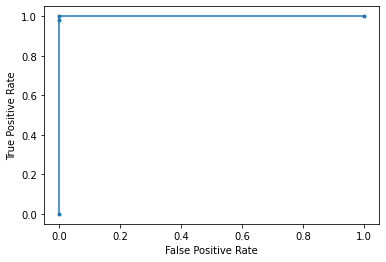

In [12]:
# Calculate ROC curve
lr_fpr, lr_tpr, _ = roc_curve(y_true, y_pred_probs)
# Plot the ROC curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show the plot
plt.show()

## Save results

In [13]:
results = pd.DataFrame({'Image':val_images,'Label':y_pred})

In [14]:
res_dict = {}
res_dict['ER'] = 1-round(accuracy,3)
res_dict['ROC'] = roc_auc
res_dict['FP'] = int(cfmtx['Pred: Fluten'].iloc[1])
res_dict['FN'] = int(cfmtx['Pred: Normal'].iloc[0])
res_dict['TIME'] = int(comp_time)

with open('results_metrics.json', 'w') as fp:
    json.dump(res_dict, fp)